## Data Processing

In [22]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [118]:
# Read in data
data = pd.read_csv("data/data_prepped_r.csv")
X = data.drop("Target", axis=1)
y = data["Target"]

label_map = {"Dropout": 1, "Graduate": 0}
y_encoded = [label_map[label] for label in y]

# Split train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42)

# Define feature types
categorical = [
    "Marital status",
    "Application mode",
    "Course",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

numeric = [col for col in X_train.columns if col not in categorical]

# Construc preprocessor to transform data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

## Models

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# Initialize logistic regression pipeline
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=5000, verbose=0))
])

# hyper-parameter grid for tuning
logreg_param_grid = [
    # For l1 and l2: excludes l1_ratio
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 0.15, 0.3],
        'classifier__class_weight': [None, 'balanced']
    },
    # For elasticnet: includes l1_ratio
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.1, 0.15, 0.3],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__l1_ratio': [0.3, 0.35, 0.4]
    }
]

# Initialize Gridsearch for 
logreg_grid_search = GridSearchCV(
    logreg_pipe,
    logreg_param_grid,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1
)

# Fit model with 3-fold CV
logreg_grid_search.fit(X_train, y_train)

print(f"Best parameters: {logreg_grid_search.best_params_}")
print(f"Best cross-validation log loss: {-logreg_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best parameters: {'classifier__C': 0.3, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.4, 'classifier__penalty': 'elasticnet'}
Best cross-validation log loss: 0.236


In [115]:
# Save the best estimator
joblib.dump(logreg_grid_search.best_estimator_, 'models/best_logreg_pipeline.joblib')

['models/best_logreg_pipeline.joblib']

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
# Create pipeline with Random Forest
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    "classifier__max_depth": [8, 10],
    "classifier__min_samples_leaf": [2, 4],
    "classifier__max_features": [0.2, 0.3],
    "classifier__bootstrap": [True, False],
    "classifier__n_estimators": [1200]
}

# Grid search with cross-validation
rf_grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1,
)

# Fit model with 3-fold CV
rf_grid_search.fit(X_train, y_train)

print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation log loss: {-rf_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1200}
Best cross-validation log loss: 0.259


In [111]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss

# Wrap with CalibratedClassifierCV
cal_model = CalibratedClassifierCV(rf_grid_search.best_estimator_, method='isotonic', cv=5)  # or method='sigmoid'
cal_model.fit(X_train, y_train)

# Predict probabilities
probs = cal_model.predict_proba(X_test)[:, 1]

# Optional: evaluate
brier = brier_score_loss(y_test, probs)
logloss = log_loss(y_test, probs)
print(f"Brier score: {brier:.4f}")
print(f"Log loss: {logloss:.4f}")


Brier score: 0.0736
Log loss: 0.2448


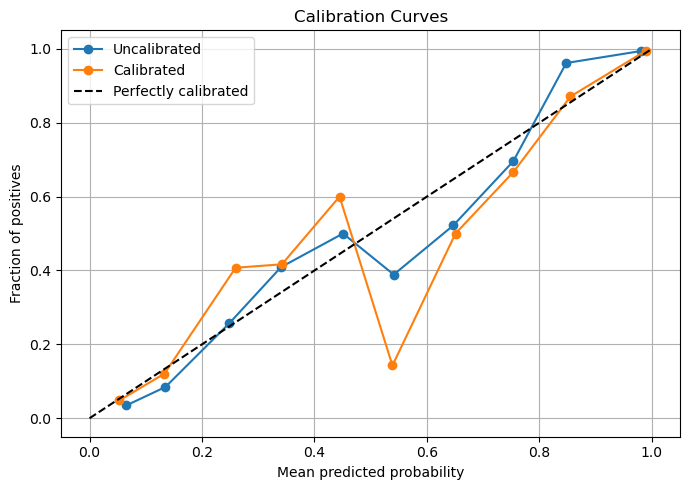

In [113]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration(y_true, prob_uncal, prob_cal):
    plt.figure(figsize=(7, 5))
    
    # Calibration curves
    for probs, label in zip([prob_uncal, prob_cal], ['Uncalibrated', 'Calibrated']):
        prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curves')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Predict probabilities
probs_uncal = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
probs_cal = cal_model.predict_proba(X_test)[:, 1]

# Plot calibration curves
plot_calibration(y_test, probs_uncal, probs_cal)


In [116]:
# Save the best estimator
joblib.dump(rf_grid_search.best_estimator_, 'models/best_rf_pipeline.joblib')

['models/best_rf_pipeline.joblib']

### XGBoost

In [31]:
import xgboost as xgb

In [32]:
# Create pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("classifier", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        enable_categorical=False,
        random_state=42,
        scale_pos_weight=1  # Use this if your classes are imbalanced
        )
    )
])

xgb_param_grid = {
    "classifier__learning_rate": [0.03, 0.035],       # Finer around 0.03
    "classifier__n_estimators": [400, 500],             # Around 400
    "classifier__max_depth": [6, 7],                      # Around 7
    "classifier__reg_lambda": [0.005, 0.01],           # Around 0.01
    "classifier__colsample_bytree": [0.2, 0.3],         # Around 0.3
    # 3 * 3 * 3 * 3 * 3 = 243 combinations
}

# Grid search with cross-validation
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1
)

# Fit model with 3-fold CV
xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation log loss: {-xgb_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'classifier__colsample_bytree': 0.2, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 6, 'classifier__n_estimators': 400, 'classifier__reg_lambda': 0.005}
Best cross-validation log loss: 0.248


In [117]:
# Save the best estimator
joblib.dump(rf_grid_search.best_estimator_, 'models/best_xgb_pipeline.joblib')

['models/best_xgb_pipeline.joblib']

## Model Results

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
results_df = pd.DataFrame(xgb_grid_search.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.761902,0.078070,0.150642,0.018493,0.2,0.03,6,400,0.005,"{'classifier__colsample_bytree': 0.2, 'classif...",-0.250372,-0.235104,-0.257690,-0.247722,0.009409,1
1,0.737951,0.026328,0.137235,0.047649,0.2,0.03,6,400,0.010,"{'classifier__colsample_bytree': 0.2, 'classif...",-0.252487,-0.234357,-0.257616,-0.248153,0.009977,2
2,0.908414,0.053349,0.134907,0.016603,0.2,0.03,6,500,0.005,"{'classifier__colsample_bytree': 0.2, 'classif...",-0.254831,-0.237845,-0.264235,-0.252304,0.010921,9
3,0.902688,0.048621,0.139963,0.024732,0.2,0.03,6,500,0.010,"{'classifier__colsample_bytree': 0.2, 'classif...",-0.257606,-0.235728,-0.263831,-0.252388,0.012052,10
4,0.991087,0.009686,0.225793,0.049010,0.2,0.03,7,400,0.005,"{'classifier__colsample_bytree': 0.2, 'classif...",-0.254805,-0.235207,-0.264725,-0.251579,0.012264,6


In [86]:
# Predict class probabilities
y_proba = pd.DataFrame(logreg_grid_search.best_estimator_.predict_proba(X_test)[:,1], columns=["LogReg"])
y_proba["RF"] = rf_grid_search.best_estimator_.predict_proba(X_test)[:,1]
y_proba["XGB"] = xgb_grid_search.best_estimator_.predict_proba(X_test)[:,1]
y_proba["True Label"] = y_test
y_proba.head()

,LogReg,RF,XGB,True Label
0,0.428652,0.588761,0.708863,0
1,0.836559,0.754105,0.759262,1
2,0.992251,0.972825,0.983577,1
3,0.103962,0.188325,0.099270,0
4,0.998207,1.000000,0.997596,1


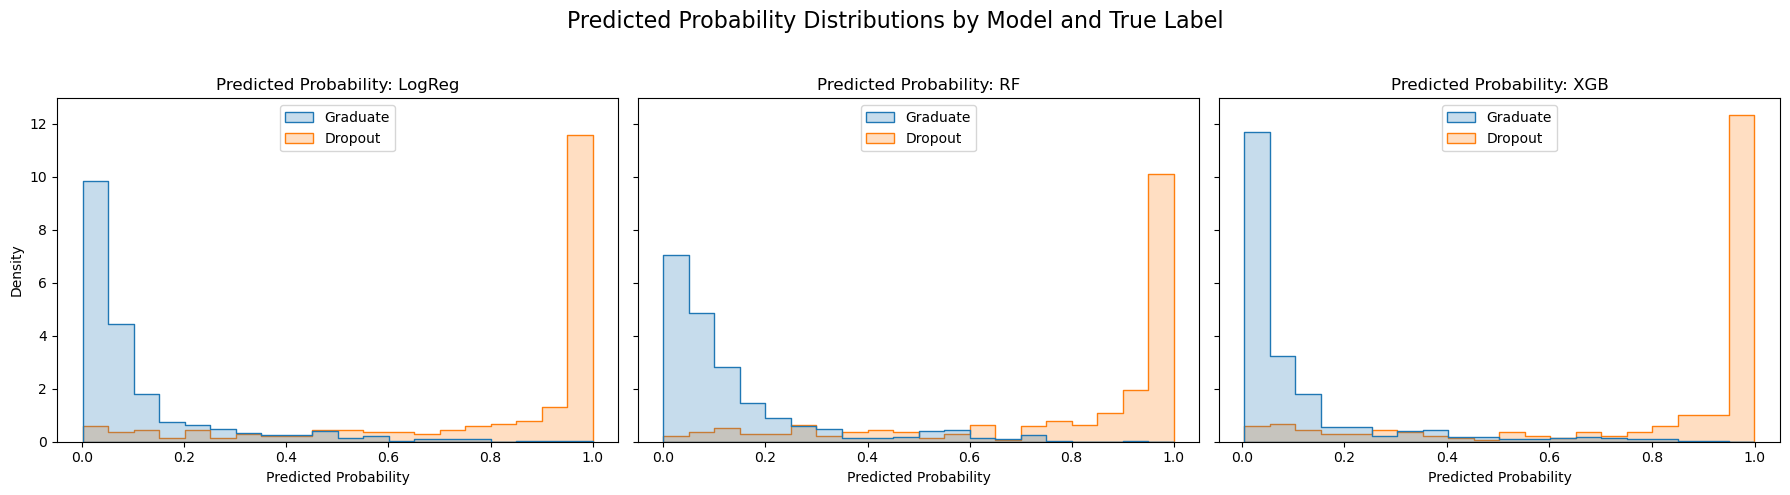

In [87]:
# List of model probability column names
model_cols = ['LogReg', 'RF', 'XGB']
custom_legend_labels = ["Graduate", "Dropout"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, model in enumerate(model_cols):
    sns.histplot(
        data=y_proba,
        x=model,
        hue='True Label',
        element='step',
        stat='density',
        common_norm=False,
        bins=20,
        ax=axes[i]
    )
    axes[i].set_title(f'Predicted Probability: {model}')
    axes[i].set_xlabel('Predicted Probability')
    if i == 0:
        axes[i].set_ylabel('Density')
    else:
        axes[i].set_ylabel('')
    
    legend = axes[i].get_legend()
    if legend is not None:
        legend.set_title("")
        for text, new_label in zip(legend.get_texts(), custom_legend_labels):
            text.set_text(new_label)

            legend.set_loc('upper center')

plt.suptitle('Predicted Probability Distributions by Model and True Label', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


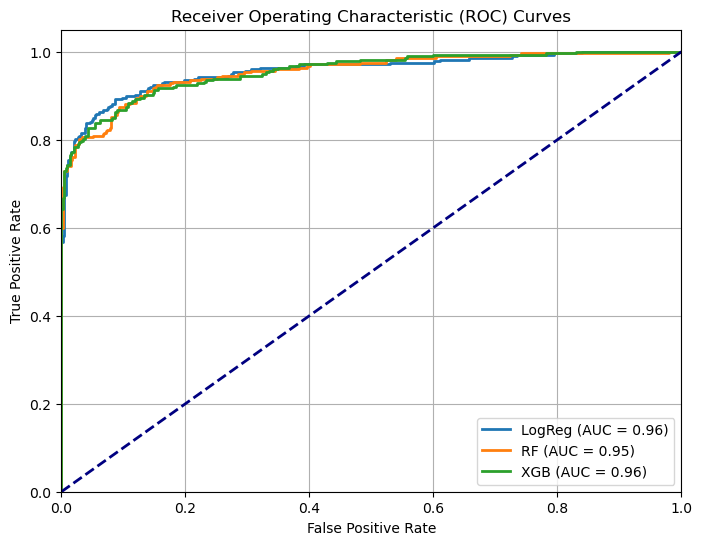

In [88]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for model_name, y_probs in y_proba.drop("True Label", axis=1).items():
    fpr, tpr, _ = roc_curve(y_proba["True Label"], y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

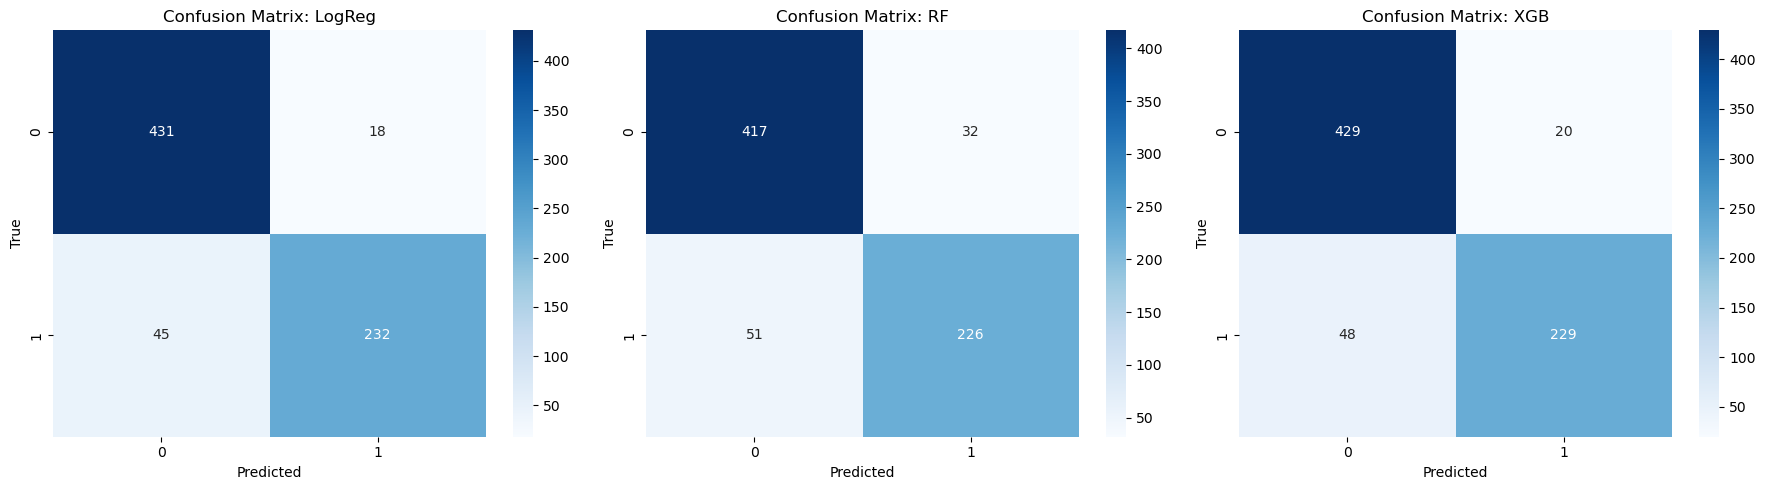

In [89]:
from sklearn.metrics import confusion_matrix

# Define model names and thresholds for converting probabilities to predicted classes
model_cols = ['LogReg', 'RF', 'XGB']
threshold = 0.5  # adjust if needed

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(model_cols):
    # Convert predicted probabilities to class labels
    y_pred = (y_proba[model] >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[0, 1],
        yticklabels=[0, 1],
        ax=axes[i]
    )
    
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix: {model}')

plt.tight_layout()
plt.show()


In [93]:
from sklearn.metrics import (
    f1_score, log_loss, accuracy_score, precision_score, recall_score
)

# Define model names and threshold
model_cols = ['LogReg', 'RF', 'XGB']
threshold = 0.5

# Initialize list to collect metric results
metrics_list = []

# Compute metrics for each model
for model in model_cols:
    y_probs = y_proba[model]
    y_pred = (y_probs >= threshold).astype(int)
    
    metrics = {
        'Model': model,
        'F1 Score': f1_score(y_test, y_pred),
        'Log Loss': log_loss(y_test, y_probs),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
    }
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Format numbers to 3 decimals (optional)
metrics_df = metrics_df.round(3)

# Display table
print(metrics_df)

    Model  F1 Score  Log Loss  Accuracy  Precision  Recall
0  LogReg     0.880     0.233     0.913      0.928   0.838
1      RF     0.845     0.248     0.886      0.876   0.816
2     XGB     0.871     0.239     0.906      0.920   0.827
